# Ex. 2 - Linear methods in 2D
In this second tutorial, we will discuss simple linear classification methods considering only two variables, we will keep dealing with the CMS dataset for $h \to \ell^+ \ell^- \nu \bar \nu$.

Let's ensure the library and the data are available, rerunning the download code as discussed in Ex. 1.

In [ ]:
!pip install uproot iminuit
files = {
    "WWTo2L2Nu1.root": "1oix_LaKYaPgMPdOcG8O6_qwq3a0CD1EO",
    "GGToHToWWTo2L2Nu1.root": "1lD3JG12bP21oN94bEmDOZuLQBd4y2Dwk",
    "WWTo2L2Nu2.root":"1KTlRb66tSPajEpJJoLqmqisBQW-Pakjk",
    "GGToHToWWTo2L2Nu2.root": "1X72-i7qrYqQyA02jCESFFlSq33__x_tq"}
!rm -f *.root
import os 
for kv in files.items():
  if not os.path.exists(kv[0]):
    a = os.system ( "wget -O %s --no-check-certificate 'https://docs.google.com/uc?export=download&id=%s'" % kv )
    if a:
      print (a)
      print ('https://docs.google.com/uc?export=download&id=%s' % kv[1])
      raise IOError ( "Could not download %s (%s)" % kv ) 

import uproot, pandas as pd
signal      = uproot.open ( "GGToHToWWTo2L2Nu2.root" )['latino'].arrays(library='pd')
background  = uproot.open ( "WWTo2L2Nu2.root" )['latino'].arrays(library='pd')
signal['label'] = 1; background['label'] = 0
dataset = pd.concat ((signal,background))



Before starting, just another technical step: plots in two dimension gets hard to read if too small, let's make the figure larger for this notebook.

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 110

### Plotting the dataset in two dimensions

When you will complete the exercise 1.1, you will find out that among the most discriminating variables there is, together with $\Delta R$, $m_{Ti}$, the 
tranverse missing mass, improved. 

This is expected because as the two charged leptons, also the two neutrino are expected to be collinear, and as for the two leptons we expect this to reflect 
into a reduced invariant mass of their combination. 

So to move from one dimension to two dimensions, let's combine the information on the angle between the charged leptons with the information on the angle between the two neutrinos. 

Since we will find ourselves plotting this dataset a few times in this notebook, we define a function grouping the lines necessary to produce a so 
called *scatter plot* where a point indicates a data entry and its coordinate
indicate the values of the two variables considered, in our case: $\Delta R$ and $m_{Ti}$.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def make_2d_plot(var1, var2, title1=None, title2=None, alpha=1.0):
  plt.plot ( signal[var1], signal[var2], 'p', alpha = 0.9*alpha, markersize = 0.1, label='signal' )
  plt.plot ( background[var1], background[var2], 'p', alpha = 0.7*alpha, markersize = 0.1, label='background' )
  plt.legend(markerscale=50)
  plt.xlabel (title1 or var1)
  plt.ylabel(title2  or var2)
  return None

Then we execute the function, we decide what scale to use for the y axis (a logaritmic scale helps visualizing the data, but makes harder to evaluate the "linearity" of the algorithms at the later stages of the analysis).

[]

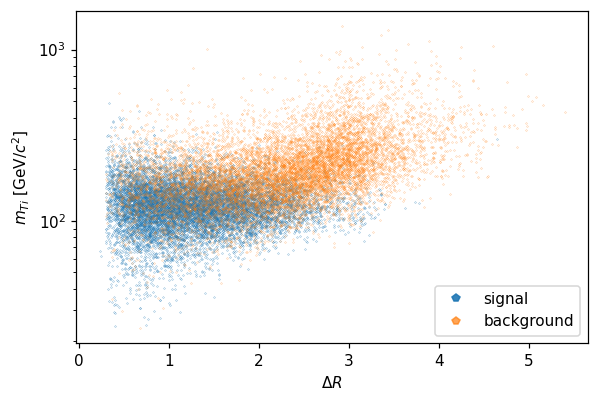

In [ ]:
make_2d_plot('drll', 'mTi', "$\Delta R$", "$m_{Ti}\  [\mathrm{GeV}/c^2]$")
plt.yscale('log')
plt.plot()

### Fisher discriminant

The first linear classification algorithm that we discuss is the Fisher discriminant. 
The main idea behind the Fisher discriminant is to approximate the *joint pdfs* 
of the two variables as multivariate Gaussians and to choose the linear combination of the variable on the axes to maximise the distance between the two centroids associated to signal and background:
$$ J(\mathbf{w}) = \frac{(E[y|\mathrm{s}] - E[y|\mathrm{b}])^2}{V[y|\mathrm{s}] + V[y|\mathrm{b}]} $$
where $y = \sum_i w_i x_i$  or $y = \mathbf{w}\cdot\mathbf{x}$ and $\mathrm{s}$ and $\mathrm{b}$ indicate the signal and background samples, respectively.

Let's start tryinig to maximise this distance by using a numerical optimization method. The most common in High-Energy Physics is MINUIT, which can be used in python through the `iminuit` interface.

In [ ]:
from iminuit import Minuit

def compute_fisher_coeffs_numerically (s_varX, s_varY, b_varX, b_varY):
  ## Let's define the distance function
  def distance_J ( w1, w2 ):
    s_y = w1*s_varX + w2*s_varY
    b_y = w1*b_varX + w2*b_varY
    s_E = np.mean (s_y)
    b_E = np.mean (b_y)
    s_V = np.std  (s_y)
    b_V = np.std  (b_y)
    return (s_E - b_E)**2 / (s_V**2 + b_V**2)
  
  ## Since with MINuit we MINimize, but we want to maximize the distance, 
  ## we define a "negative" distance. 
  def negative_J ( w1, w2 ):
    return -distance_J (w1, w2)
  
  ## Finally we use the verbose iminuit interface to minimize 
  m = Minuit(negative_J, w1 = 1, w2 = 1) 
  m.errors = (1.,1.)
  res = m.migrad()

  ## And return the values
  return  m.values

The good thing of the distance J is that it can be maximized analytically, imposing $$\nabla J = 0$$ and solving the resulting algeabric equation.
The maximum of $J$ is obtained for:
$$ w \propto W^{-1} (\mathbf{\mu_s} - \mathbf{\mu_b}) $$
where $W$ is the sum of the covariance matrices computed on the signal and background samples, while $\mu_s$ and $\mu_b$ are the averages of the 
$x_i$ variables computed separately for the signal and background samples.

Back to coding, this is the function that computes the coefficients of the Fisher discriminant for a two-variate problem:

In [ ]:
def compute_fisher_coeffs_analytically (s_varX, s_varY, b_varX, b_varY):
  s_cov = np.cov ( np.array([s_varX, s_varY]) )
  b_cov = np.cov ( np.array([b_varX, b_varY]) )
  deltaMu = np.array ([ [s_varX.mean() - b_varX.mean()], 
                        [s_varY.mean() - b_varY.mean()]] )
  
  coeffs = np.linalg.inv(b_cov + s_cov) @ deltaMu 
  return coeffs

Let's try to superpose the result of the classification we can obtain with a Fisher discriminant to the dataset to visualize where the boundaries between the signal and the background would look like.

Clearly, since we have not defined the amount of selected background that we would consider acceptable, the result will be a set of linear boundaries at various levels of the signal purity. 

 > Try to modify the plot to use the log-scale for the y axis.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)


[]

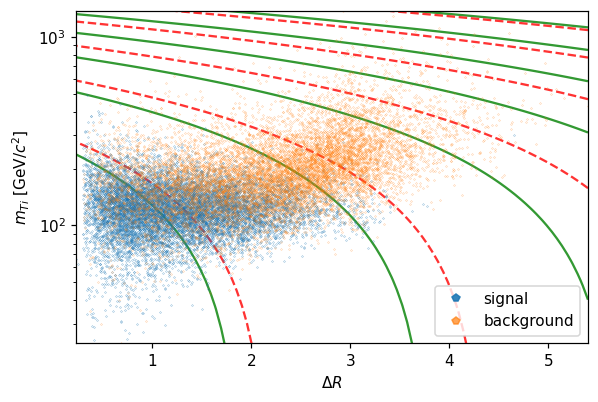

In [ ]:
## We compute the Fisher coefficients
wx, wy = compute_fisher_coeffs_analytically ( 
    signal['drll'], signal ['mTi'], background['drll'], background['mTi'] 
  )

num_wx, num_wy = compute_fisher_coeffs_numerically ( 
    signal['drll'], signal ['mTi'], background['drll'], background['mTi'] 
  )

## We create a grid of 100x100 values for x and y 
x_ = np.linspace ( dataset['drll'].min(),  dataset['drll'].max(), 100 )
y_ = np.linspace ( dataset['mTi'].min(),   dataset['mTi'].max(),  100 )
x,y = np.meshgrid (x_,y_)

## We compute the value of the test-statistic on each point of the grid,
##  both numerically
test_statistic = num_wx * x + num_wy * y
##  and analytically
num_test_statistic = wx * x + wy * y

## We plot the 2D distributions of the two datasets
make_2d_plot('drll', 'mTi', "$\Delta R$", "$m_{Ti}\  [\mathrm{GeV}/c^2]$")

## We superpose the distributions to the boundaries obtained a "contour" of the 
## test-statistic function
plt.contour ( x,y,test_statistic, colors = 'green', alpha = 0.8 )
plt.contour ( x,y,num_test_statistic, colors = 'red', alpha = 0.8 )

## We choose the scale and we plot
plt.yscale('log')
plt.plot()

As for the 1D case, we compute the distribution of the test-statistic for the signal and the background to visualize the separation between the two datasets.

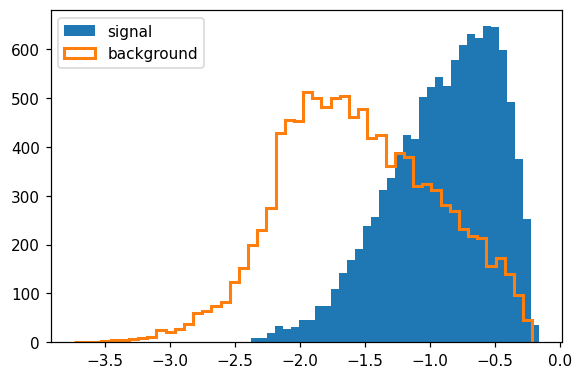

In [ ]:
wx, wy = compute_fisher_coeffs_analytically ( signal['drll'], signal ['mTi'], background['drll'], background['mTi'] )
s_y = wx * signal['drll'] + wy * signal['drll']
b_y = wx * background['drll'] + wy * signal ['drll']

plt.hist ( s_y, bins = 50, label = 'signal' )
plt.hist ( b_y, bins = 50, linewidth = 2, histtype='step', label = 'background' )
plt.legend()
plt.show()

### Exercise 2.1
Compute and superpose the ROC curves obtained with the variables $\Delta R$ and $m_{Ti}$ separately and by using the Fisher discriminant.

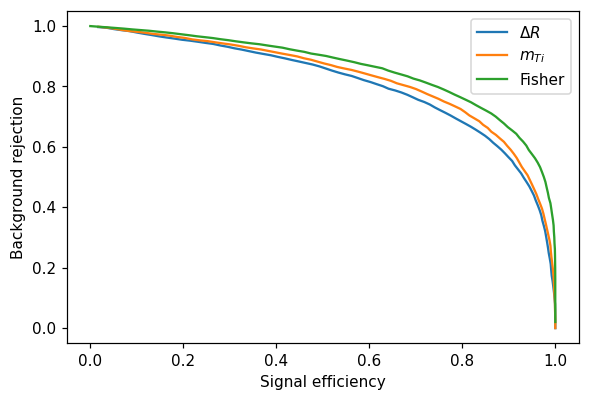

In [ ]:
## Solution to be hidden for students

## Note, this solution is short, but uses as test statistic the variables 
## themselves which is slighly improper.
isSignal = dataset['label'] == 1
xVar     = dataset['drll'].values
yVar     = dataset['mTi'].values
wx, wy   = compute_fisher_coeffs_analytically ( xVar[isSignal], yVar[isSignal], xVar[~isSignal], yVar[~isSignal] )
z        = wx*xVar + wy*yVar

xCuts = np.quantile(xVar, np.linspace(0,1,100))
yCuts = np.quantile(yVar, np.linspace(0,1,100))
zCuts = np.quantile(z, np.linspace(0,1,100))

x_sigEff = np.cumsum ( np.histogram (xVar[isSignal], bins=xCuts)[0] )
y_sigEff = np.cumsum ( np.histogram (yVar[isSignal], bins=yCuts)[0] )
z_sigEff = np.cumsum ( np.histogram (z   [isSignal], bins=zCuts)[0] )

x_bkgRej = np.cumsum ( np.histogram (xVar[~isSignal], bins=xCuts)[0] )
y_bkgRej = np.cumsum ( np.histogram (yVar[~isSignal], bins=yCuts)[0] )
z_bkgRej = np.cumsum ( np.histogram (z   [~isSignal], bins=zCuts)[0] )

plt.plot ( x_sigEff/x_sigEff[-1], 1.-x_bkgRej/x_bkgRej[-1], label = '$\Delta R$' )
plt.plot ( y_sigEff/y_sigEff[-1], 1.-y_bkgRej/y_bkgRej[-1], label = '$m_{Ti}$' )
plt.plot ( 1.-z_sigEff/z_sigEff[-1], z_bkgRej/z_bkgRej[-1], label = 'Fisher' )
plt.legend()
plt.xlabel ( "Signal efficiency")
plt.ylabel ( "Background rejection")
plt.show()


### Parametric likelihood ratio
Completing the Exercise 2.1 you will find that the Fisher discriminant works: it combine the information from the two variables into a single, more discriminant test statistic. 
However, we made a very strong assumption, we assumed that the two distributions for the *signal* and *background* categories can be modeled with two multivariate Gaussian distributions. 

If this assumption holds, then the Fisher discriminant is the most powerful discriminant method. More than neural networks and density estimation trees, but unfortunately the assumption holds only very rarely. 

To understand better the role of this assumption let's try to explicitely model the two distributions with multivariate Gaussians and to compute the likelihood ratio. For the Neyman-Pearson lemma we know that (under the usual assumption) this leads to the most-powerful test-statistic.

First, we define a function that models a dataset with a two-variate Gaussian and return the evaluation of that *pdf* on a grid. 


In [ ]:
def estimate_gaussian (varX, varY, x_ = None, y_ = None):
  x_ = x_ if x_ is not None else np.linspace(varX.min(),varX.max(),100)
  y_ = y_ if y_ is not None else np.linspace(varY.min(),varY.max(),100)
  x,y = np.meshgrid (x_,y_)
  cov = np.cov ( np.array([varX, varY]) )

  xy  = np.array ( [x - varX.mean(), y - varY.mean()] )
  z = (np.exp(-0.5 * np.einsum ( 'iab,ij,jab->ab', xy, np.linalg.inv(cov), xy)))

  return x, y, z

Then, let's see it in action. We plot the two Gaussian distributions superposed to the scatter plot to visualize where their extent and shape.

> Note that in log scale the two Gaussian pdfs look deformed, but this is only due to a deformation of the axes. Resetting linear scaler for both axes you will see the two Gaussian symmetric with respect to the centroid.

[]

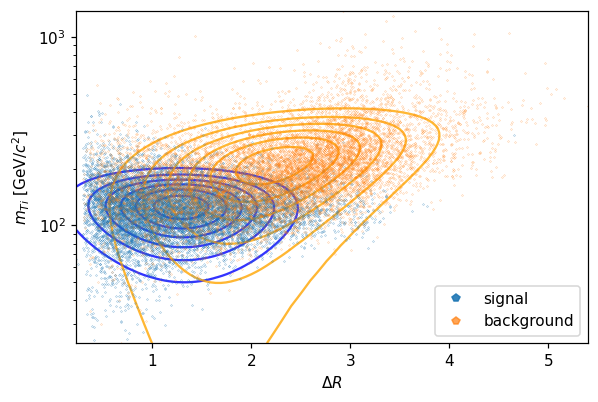

In [ ]:
make_2d_plot('drll', 'mTi', "$\Delta R$", "$m_{Ti}\  [\mathrm{GeV}/c^2]$")

s_x, s_y, s_z = estimate_gaussian ( signal['drll'], signal ['mTi'])
b_x, b_y, b_z = estimate_gaussian ( background['drll'], background ['mTi'])

plt.contour ( s_x,s_y,s_z, colors = 'blue', alpha = 0.8 )
plt.contour ( b_x,b_y,b_z, colors = 'orange', alpha = 0.8 )
plt.yscale('log')
plt.plot()

Now that we have a Gaussian model for the probability density function of the two distributions, we can take the ratio and call that a *likelihood ratio*.
To deal with the tails, where one of the two distribution vanishes quickly making the ratio to explode, we use the logatithm of the likelihood ratio, or the difference of the logarithms of the likelihood:
$$ \log \frac{\mathcal L_{\mathrm{sig}}}{\mathcal L_{\mathrm{bkg}}} = 
\log \mathcal L_\mathrm{sig} - \log \mathcal L_{\mathrm{bkg}} $$


In [ ]:
## Create the axes
x_ = np.linspace ( dataset['drll'].min(), dataset['drll'].max(), 1000)
y_ = np.linspace ( dataset['mTi'].min(),  dataset['mTi'].max(),  1000)

s_x, s_y, s_z = estimate_gaussian ( signal['drll'], signal ['mTi'], x_, y_)
b_x, b_y, b_z = estimate_gaussian ( background['drll'], background ['mTi'], x_, y_)

ll = np.clip ( np.log ( s_z / b_z ), -8, 8)

Since the function `estimate_gaussian` return the estimation on a grid, also the likelihood ratio computed on top of the estimated Gaussians will be evaluated on a grid.

We can then easily superpose it to the scatter plot to see how the selection boundaries between signal and background would look like.

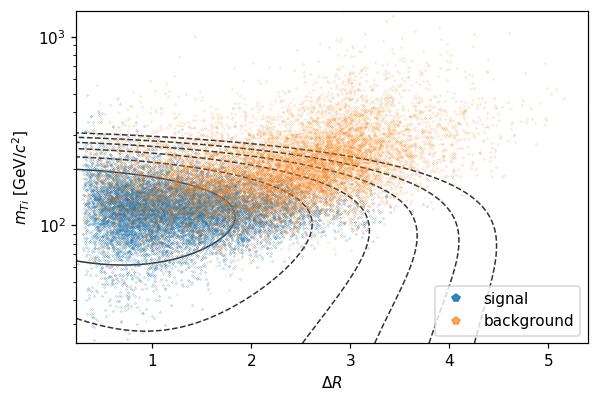

In [ ]:
make_2d_plot('drll', 'mTi', "$\Delta R$", "$m_{Ti}\  [\mathrm{GeV}/c^2]$")
plt.contour ( b_x,b_y,ll, colors = 'black', alpha = 0.8, linewidths = 1 )
plt.yscale ( 'log' )

In the region where **there is** signal, the boundaries look very similar to those obtained with the Fisher discriminant, on the tails this is not true. Indeed, the *likelihood* ratio is not a linear method, so the boundaries are not straight lines, but is this any better of the Fisher discriminant?

To answer this question, we use the likelihood ratio as a test-statistic. 

We define a function to obtain the log-likelihood, in symbols
$$ \log \mathcal L (\mathbf{x}; \mu, V) = \frac{1}{\sqrt{2\pi\, \mathrm{det}\,{V}}}
\ \exp \left ( - \frac{1}{2} (\mathbf{x} - \mathbf{\mu})^\mathrm{T}V^{-1} (\mathbf{x} - \mathbf{\mu}) \right) $$

In [ ]:
def get_ll ( xy, mu, cov ):
  icov = np.linalg.inv ( cov )
  detcov = np.linalg.det ( cov )
  return np.log ( 
      1./ np.sqrt(2*np.pi*detcov) * 
      np.exp(-0.5 * np.einsum ( "ej,jk,ek->e", xy - mu, icov, xy - mu ))
     )

we apply then the function to the dataset to compute, for each data entry the likelihood of the *signal* and *background* hypotheses
$$ \log \mathcal L_{\mathrm{sig}} = \log \mathcal L (\mathbf{x} | \mathrm{signal}) = \log \mathcal L \Big(\mathbf{x};  E(\mathrm {x_\mathrm{sig}}), \mathrm{cov}( \mathrm{x_\mathrm{sig}} ) \Big) $$
$$ \log \mathcal L_{\mathrm{bkg}} = \log \mathcal L (\mathbf{x} | \mathrm{background}) = \log \mathcal L \Big(\mathbf{x};  E(\mathrm {x_\mathrm{bkg}}), \mathrm{cov}( \mathrm{x_\mathrm{bkg}} ) \Big) $$

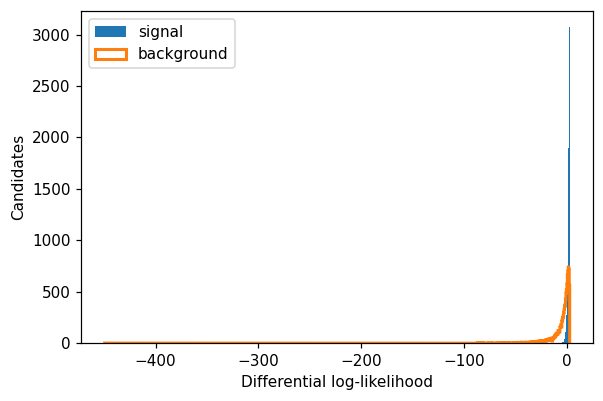

In [ ]:
## Reload the dataset
xy = dataset[['drll', 'mTi']].values
isSignal = (dataset['label'] == 1)

## Compute the mean vectors 
s_mu = np.mean ( xy[isSignal],  axis = 0)
b_mu = np.mean ( xy[~isSignal], axis = 0)

## Compute the covariance matrices 
s_cov = np.cov ( xy[isSignal].T  )
b_cov = np.cov ( xy[~isSignal].T )

## Use the defined function 
s_ll = get_ll (xy, s_mu, s_cov)
b_ll = get_ll (xy, b_mu, b_cov)

## Compute the log likelihood ratio 
dll = s_ll - b_ll

## Finally, we fill two histograms and we plot them 
dllAxis = np.linspace ( dll.min(), dll.max(), 1000 )
plt.hist ( dll[isSignal] , bins = dllAxis, label = 'signal')
plt.hist ( dll[~isSignal], bins = dllAxis, histtype='step', linewidth=2, label='background')
plt.legend()
plt.xlabel ( "Differential log-likelihood" )
plt.ylabel ( "Candidates" )
plt.show()

This test-statistic is difficult to read because it is "pushed" towards higher values with a long tail towards negative values, populated by background-like events.

This means that, as it often happens, it is *easy* for the algorithm to identify events that are certanily due to background combinations, while it is tough to eliminate the background when selecting the signal.

To make the test-statistic more "readable" we can transform it to populate the range $(0, 1)$. This transformation can be obtained with the cumulative function.

$$ F(x) = \int_{-\infty}^x  f(x') \, \mathrm d x' $$

If the pdf $f$ is the distribution of the test-statistic of either the signal or background components, this operation is called *flattening* and gives to the test-statistic a clear statistical meaning. For example, if you *flatten* the background distribution and you obtain a test-statistic ${t_\mathrm b}$, the requirement $t_b > 0.3$ means that we are retaining $70\%$ of the background events. 

 > Note the usage of the `quantile` function of numpy, combined with `interp` to compute the cumulative distribution and use it as a function.

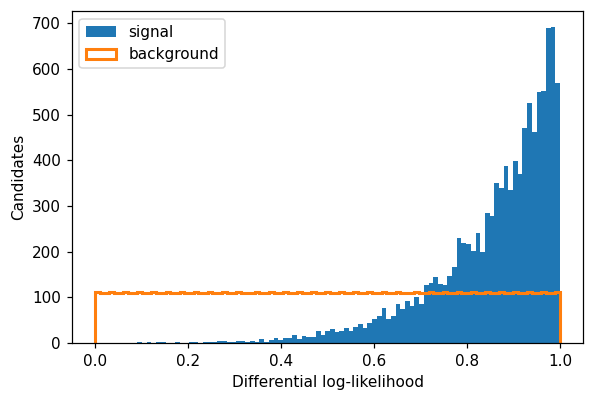

In [ ]:
q = np.linspace ( 0., 1., 100 )
transformed_dll = np.interp( dll, np.quantile ( dll[~isSignal], q ), q )

plt.hist ( transformed_dll[isSignal] , bins = q, label = 'signal')
plt.hist ( transformed_dll[~isSignal], bins = q, histtype='step', linewidth=2, label='background')
plt.legend()
plt.xlabel ( "Differential log-likelihood" )
plt.ylabel ( "Candidates" )
plt.show()

We are ready to compute the ROC curve of the likelihood ratio and compare it with that of the Fisher discriminant.

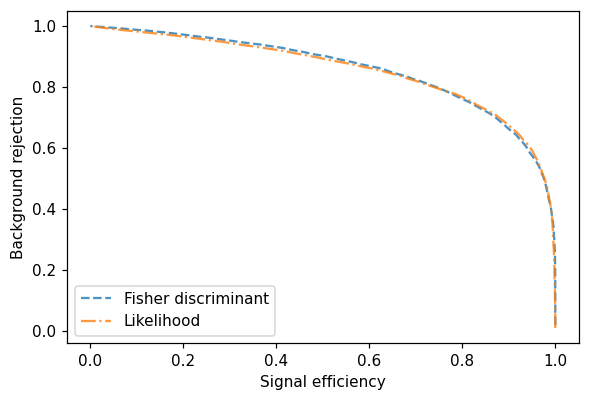

In [ ]:
## Reload the dataset
xy = dataset[['drll', 'mTi']].values

## Compute the Fisher discriminant
wx, wy   = compute_fisher_coeffs_analytically ( xVar[isSignal], yVar[isSignal], xVar[~isSignal], yVar[~isSignal] )
f        = wx*xy[:,0] + wy*xy[:,1]

## Computes the number of signal and background events
nSig = np.count_nonzero(isSignal)
nBkg = np.count_nonzero(~isSignal)

## Compute the signal efficiency
fCuts = np.quantile(f, np.linspace(0,1,100))
f_sigEff = 1.-np.cumsum ( np.histogram (f [isSignal], bins=fCuts)[0] / nSig  )
l_sigEff = 1.-np.cumsum ( np.histogram ( transformed_dll[isSignal], bins = q )[0] / nSig )

## Compute the background rejection
f_bkgRej = np.cumsum ( np.histogram (f   [~isSignal], bins=fCuts)[0] / nBkg )
l_bkgRej = np.cumsum ( np.histogram (transformed_dll [~isSignal], bins = q )[0] / nBkg)

## Produce the plot
plt.plot ( f_sigEff, f_bkgRej, '--', label = 'Fisher discriminant', alpha = 0.8 )
plt.plot ( l_sigEff, l_bkgRej, '-.', label = 'Likelihood',  alpha = 0.8 )
plt.legend()
plt.xlabel ( "Signal efficiency")
plt.ylabel ( "Background rejection")
plt.show()

as expected, the two ROC curve are almost identitical. We used a linear and a non-linear method, relying on the same hypothesis and we got the same result. 

In the next section we will try to avoid using any assumption on the Gaussian shape of the two distributions for *signal* and *background*, while retaining the linearity of the Fisher discriminant.

### Logistic regression

The Fisher discrimimant relies on an intuitive definition of distance between the centroids of two functions, but we know that statistics offers us a hammer that we can use to solve most problems: the *maximum likelihood principle*. 

Let's recall the *maximum likelihood principle*. We define the likelihood as
$$ \mathcal L(\theta) = \prod_i\, p\, (x_i; \theta), $$
where
 * $x_i$ is the $i$-th entry of a dataset composed of several variables
 * $p$ is the probability that $x_i$ belongs to the dataset and depends 
   on a set of parameters $\theta$

The *maximum likelihood principle* states that the parameters $\theta$ can be estimated by maximising the likelihood
$$ \hat \theta = \mathop{\mathrm{argmax}}_\theta \mathcal L(\theta) $$

How can we describe the problem of classification with the *maximum likelihood principle*?

First of all, we need an expression for the probability $p$.
For a binary classification, with two classes, the probability that the element $x_i$ belongs to the signal sample is, say, $P$. Clearly, the probability that the same event belongs to the background sample will be $1 - P$. In forumla,

$$ p(x_i) = \left\{
    \begin{array}{ll}
      P \qquad &\mbox{if $x_i$ is a signal entry} \\  
      1 - P \qquad &\mbox{if $x_i$ is a background entry} 
    \end{array}
  \right.$$

This probability density function is named **Bernoulli** distribution.

  Now, we not only interested into the overall probability that the sample contains a signals or background events, we want to know to model the probability that the event belongs to the signal category as a function of some parameter, for example $\Delta R$ and $m_{Ti}$. These parameters are summarized into the symbol $\theta$. 

$$ p(x_i; \theta) = \left\{
    \begin{array}{ll}
      P (\theta) \qquad &\mbox{if $x_i$ is a signal entry} \\  
      1 - P (\theta) \qquad &\mbox{if $x_i$ is a background entry} 
    \end{array}
  \right.$$

The likelihood can then be written as 
$$ 
\mathcal L(\theta) = 
  \prod_{\mathrm{signal}} P(\theta) \times
  \prod_{\mathrm{background}} (1 - P(\theta))
$$
or, equivalently
$$ 
\log \mathcal L(\theta) = 
  \sum_{\mathrm{signal}} \log P(\theta) +
  \sum_{\mathrm{background}}  \log (1 - P(\theta))
$$

To write the loglikelihood in a more compact form, let's define a **label** variable 
$$ 
y_i = \left\{
    \begin{array}{ll}
      1 \qquad &\mbox{if the $i$-th event belongs to the signal category} \\  
      0 \qquad &\mbox{if the $i$-th event belongs to the background category} 
    \end{array}
  \right.
$$
so that 
$$ 
\log \mathcal L(\theta) = 
  \sum_{i} \big( y_i \log P(\theta) + (1-y_i) \log (1 - P(\theta)) \big)
$$

The expression that we need to minimize is the negative log-likelihood.
$$ 
\boxed{
- \log \mathcal L(\theta) = 
  - \sum_{i} \big( y_i \log P(\theta) + (1-y_i) \log (1 - P(\theta)) \big)
}
$$

This expression is very important quantity in classification problems and it is named **binary cross-entropy classification** or **Bernoulli cross-entropy classification**.

 > **Where is the linearity?**

The validity of the above discussion is independent on the choice of the functional form of $p(x_i; \theta)$. We can model it with a linear formula?
$$ p(x_i, \theta)\mathop{=}^? w_0 + \sum_v \theta_v x^{(v)}_i $$

Unfortunately, in practice this does not work because the definition is not limited to the interval $(0,1)$ which results in value outside of the valid domain of $\mathcal L (\theta)$. Indeed $\log p$ would not be defined for $p < 0$  and $\log (1 - p)$ is not defined for $p > 1$.

Hence, we need to map values from $(-infty, +infty)$ to $(0,1)$. The most common function for this mapping is the sigmoid:
$$
  \mathrm{sigmoid}(x) = \sigma (x) = \frac{e^x}{e^x + 1} = \frac{1}{1 + e^{-x}}
$$

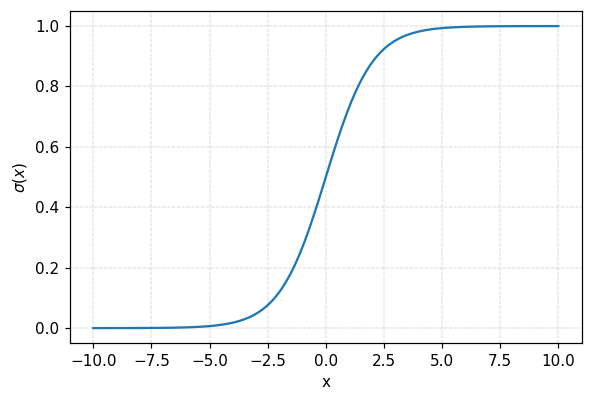

In [ ]:
def sigmoid ( x ):
  return 1. / ( 1. + np.exp ( - x ) )

xAxis = np.linspace(-10,10,100)
plt.plot (xAxis, sigmoid (xAxis))
plt.xlabel ("x"); plt.ylabel ("$\sigma(x)$")
plt.grid(linestyle='-.', linewidth=0.3) 
plt.show()

The we can defnie the probability as 
$$
  p ( x; \theta ) = \sigma \left ( w_0 + \sum_v \theta_v x^{(v)}_i  \right )
$$

and the *negative log-likelihood*
$$
- \log \mathcal L = - \!\!\!\! \sum_{x\ \in\ \mathrm{signal}} \!\!\! 
                    \log (p(x; \theta)) \,
                    - \!\!\!\!\!\!\!
                    \sum_{x\ \in\ \mathrm{background}} \!\!\!\!\!\!\!
                    \log (1 - p(x; \theta))  
$$

In [ ]:
def probIsSignal ( xy, w1, w2, w3 ):
  epsilon = 1e-5
  return np.clip ( sigmoid ( w1*xy[:,0] + w2*xy[:,1] + w3 ), epsilon, 1.-epsilon )

def likelihood ( w1, w2, w3 ):
  p = probIsSignal ( xy, w1, w2, w3 )
  return - np.sum ( np.log ( p[isSignal] ) ) - np.sum ( np.log (1. - p[~isSignal]) ) 

Minimizing this *log-likelihood* we obtain a linear expression for a test-statistic, similar to the Fisher discriminant but obtained *without* relying on the assumption that the two distributions are Gaussians. 

 > This is named a **logistic regression**.

In [ ]:
## Let's reload the X variables 
xy = dataset[['drll', 'mTi']].values
isSignal = (dataset['label'] == 1)

## and minimize the likelihood defined above with Minuit
m = Minuit (likelihood, w1 = 1, w2 = 1e-3, w3 = 0)
m.errors = (1., 1., 1.)
m.migrad()

w1, w2, w3 = m.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Note that now we need three parameters instead of the two parameters defining the Fisher discrimimant. This happens because the Fisher discriminant defines a "direction" in the parameter space. Cutting along that direction we obtain the best separation between the variables, but we assign no special meaning to the variable obtained from the linar combination of the features. 

With the logistic regression, instead, the test-statistic has a statistical meaning: it's the probability that an entry belongs to the signal category (**in the training sample!**). This requires an additional constant to define the *scale* of the test-statistic. 

We can now plot the boundaries obtained with different cuts on this test-statistics superposed to the scatter plot.

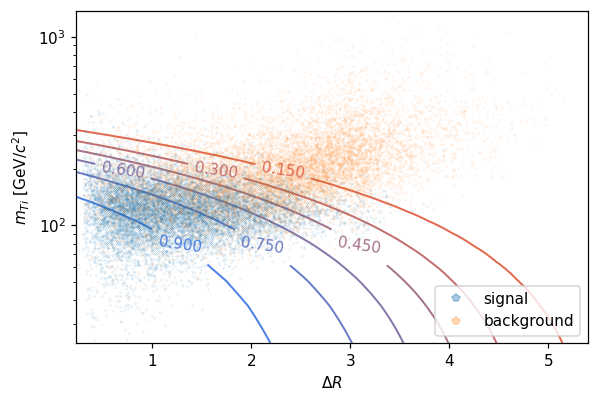

In [ ]:
## Let's define two axes with 100 "ticks"
x_ = np.linspace ( xy[:,0].min(), xy[:,0].max(), 100 )
y_ = np.linspace ( xy[:,1].min(), xy[:,1].max(), 100 )

## And a meshgrid of 100x100 points. 
test_statistic = sigmoid (sum(np.meshgrid(x_*w1,y_*w2)) + w3)
## This instruction deserve some additional discussion:
## - first we multiply the axes x_ * w1 and y_ * w2 
## - the two resulting vectors of 100 elements is used to create a two grids
##    . the X grid, X_ij = x_i * w1 
##    . the Y grid, Y_ij = y_j * w2
## - We sum the two grids and add the constant term w3: G_ij = X_ij + Y_ij + w3
## - Finally, we apply the sigmoid function to each element and we get
##   Ts_ij = sigmoid ( w1 * x_i + w2 * x_j + w3 )

## PRO TIP, the same result can be obtained with the external-product rule 
## of numpy broadcasting 
test_statistic = sigmoid(w1 * x_  + w2 * y_.reshape((-1,1)) + w3)

## And then we draw... 
nCol = 7
colors = np.c_[
        np.linspace (1.0,0.3,nCol),
        np.linspace (0.4,0.5,nCol),
        np.linspace (0.2,0.9,nCol)
    ]

make_2d_plot('drll', 'mTi', "$\Delta R$", "$m_{Ti}\  [\mathrm{GeV}/c^2]$", alpha=0.42)
cts = plt.contour(x_, y_, test_statistic, levels=nCol,
            colors=colors.tolist(), linewidths=1.3,  alpha=1.0)
plt.clabel (cts, inline=1, fontsize=10)
plt.yscale ('log')
plt.show()

This time the values of the test-statistic has a meaning: the probability that a point with those values of $\Delta R$ and $m_{Ti}$ belongs to the *signal* category.

As usual, the next step is to plot the histogram of the test-statistic for the signal and background samples, separately.

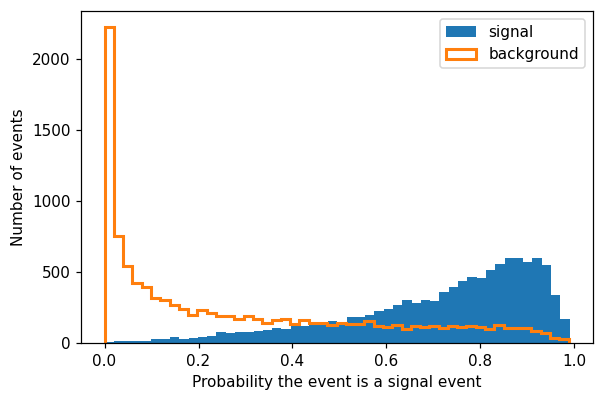

In [ ]:
test_statistic = probIsSignal ( xy, w1, w2, w3 )

plt.hist (test_statistic[isSignal], bins = 50, label='signal', alpha=1.0)
plt.hist (test_statistic[~isSignal], bins = 50, histtype='step', linewidth=2, 
          label='background', alpha=1.)
plt.xlabel ("Probability the event is a signal event")
plt.ylabel ("Number of events")
plt.legend()
plt.show()

And to plot the ROC curve.

Here, we will superpose the ROC obtained from the **logistic regression** with the ROC obtainied earlier for the **Fisher discriminant** and the **likelihood** ratio obtained modelling the two distributions as Gaussians.

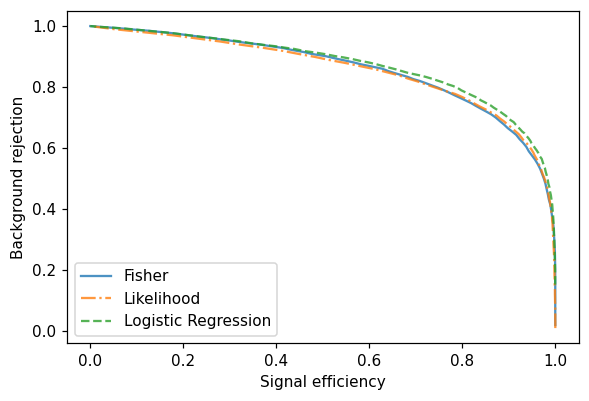

In [ ]:
xy = dataset[['drll', 'mTi']].values

wxf, wyf = compute_fisher_coeffs_analytically ( xVar[isSignal], yVar[isSignal], xVar[~isSignal], yVar[~isSignal] )
f        = wxf*xy[:,0] + wyf*xy[:,1]
p        = probIsSignal ( xy, w1, w2, w3 )

nSig = np.count_nonzero(isSignal)
nBkg = np.count_nonzero(~isSignal)

q = np.linspace (0, 1, 100)
fCuts = np.quantile(f, np.linspace(0,1,100))
f_sigEff = 1.-np.cumsum ( np.histogram (f [isSignal], bins=fCuts)[0] / nSig  )
l_sigEff = 1.-np.cumsum ( np.histogram ( transformed_dll[isSignal], bins = q )[0] / nSig )
p_sigEff = 1.-np.cumsum ( np.histogram ( p[isSignal], bins = q )[0] / nSig )

f_bkgRej = np.cumsum ( np.histogram (f   [~isSignal], bins=fCuts)[0] / nBkg )
l_bkgRej = np.cumsum ( np.histogram (transformed_dll [~isSignal], bins = q )[0] / nBkg)
p_bkgRej = np.cumsum ( np.histogram ( p[~isSignal], bins = q )[0] / nBkg )

plt.plot ( f_sigEff, f_bkgRej, '-', label = 'Fisher',      alpha = 0.8 )
plt.plot ( l_sigEff, l_bkgRej, '-.', label = 'Likelihood',  alpha = 0.8 )
plt.plot ( p_sigEff, p_bkgRej, '--', label = 'Logistic Regression',  alpha = 0.8 )
plt.legend()
plt.xlabel ( "Signal efficiency")
plt.ylabel ( "Background rejection")
plt.show()

The separation obtained with the **logistic regression** is slightly better than the separation obtained with the other two methods?

Let's stress this result: in this example
 * a linear method (logistic regression) performs better than a non-linear method (the likelihood ratio)
 * the *likelihood ratio* is demonstrated to be the most powerful test-statistic, nonetheless the test-statistic obtained with the logistic regression performs better.

 ![Where is your GOD now?](https://i.pinimg.com/originals/3a/fb/4a/3afb4ad933d3601e4e505755857c1b25.jpg)

The Neyman-Pearson lemma is not wrong, but we have approximated the probability density functions used to compute the likelihood, and the approximation is sufficiently crude that degrades the performance of the classifier.

This is the real problem with the likelihood-ratio method, usually se need to parametrize somehow the likelihood and the parametrization of a multivariate function is often non trivial. 
The approximations that we introduce in the parametrization of the likelihood may result into a degradation of the resulting classifier. 

It is worth to spend a few other lines to comment on the fact that a linear method behaves better than a non-linear method. The linearity of the model is only one of the many possible assumptions, here by chance, it is weaker to assume that the problem can be modeled with a linear classifier than to assume that the two distributions are multivariate Gaussians, and then the linear model not relying on this second stronger assumption behaves better.

This leads to the crucial discussion on the assumptions injected in the choice of any multivariate analysis, summarized in the **no free lunch theorem**.

> **No free lunch theorem** (super-short version):
> Any two optimization algorithms are equivalent when their performance is
> averaged across all possible problems [from [Wikipedia](https://en.wikipedia.org/wiki/No_free_lunch_theorem)].

The direct consequence of the NFL theorem is that there is not a thing such a "better algorithm", but at most an "algorithm more suited for a given problem". An algorithm exploits certain hypotheses to perform a classification (or other task based on an optimization) such as the continuity of the *pdf*`s or, back to the Fisher discrimimant, that they can be modeled as multivariate Gaussians. 

Therefore, when choosing a machine-learning algorithm to perform some task, the right question to ask is always what are the hypotheses that I am willing to inject in the solution to my problem.


Well... at least that's the theory. **In practice, you try them all**.

# Using scikit-learn

Most of the operations to evaluate the performance of a classification algorithm are repetitive and common to all possible algorithms.
We have seen some examples, such as drawing the ROC curve or the computation of the Kolmogorov Distance to establish some metric on the performance of an algorithm, but there are many other examples some of which will be treated in the next exercises. 

For this reason, a Python library collecting several algorithm and standardizing these common operations has become very popular: it is `scikit-learn`. 
In the most recent times, `scikit-learn` has been considered slightly "out-of-fashon" because artificial neural networks became so popular that packaged dedicated uniquely to these algorithms have replaced `scikit-learn` as the most-obvious tool to solve some problem, but `scikit-learn`is still considered a package of exceptional quality. 

`scikit-learn` provides a collection of many algorithms for regression and classification tasks, all of them provide:
 * a constructor defining the hyper-parameters of the algorithm
 * a `fit (X, y)` method to train the algorithm on a dataset `X` on label `y`
 * a `predict (X)` method that predicts the values of `y` given `X` according to the set of rules constructed when `fitting`. 

 The classification algorithms also include a method
 `predict_proba (X)` that is used to predict a probability that each entry belongs to a given category. 

 Of course, `scikit-learn` include methods for the Fisher discrimimant (`LinearDiscriminantAnalysis`) and the Logistic Regression (`LogisticRegression`). 

 The structure of scikit-learn allows to test and compare the performace of algorithms in a very simple way just replacing the constructor and letting the rest of the code unchanged. 

 Let's see scikit-learn in action.

 We start with the Fisher discriminant analysis. 
 Note that scikit-learn performs an additional step with respect to what we discussed above, to predict the probability instead of a simple test-statstic.

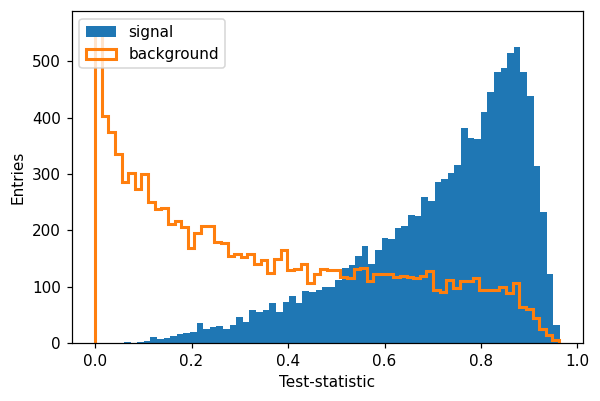

In [ ]:
## Import the Linear Discriminant Analysis from scikit-learn (sklearn)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Load the dataset
xy = dataset[['drll', 'mTi']].values
isSignal = (dataset['label'] == 1)

## Instanciate the LinearDiscriminantAnalysis (no hyperparameter configuration)
clf = LinearDiscriminantAnalysis()

## Compute the w parameters analytically 
clf.fit(xy, dataset['label'])

## And then predicts the probabilities 
fisher = clf.predict_proba (xy)

## Then we plot the histograms of the test-statistic
plt.hist(fisher[isSignal,1], bins=70, label = 'signal')
plt.hist(fisher[~isSignal,1], bins=70, histtype='step', linewidth=2, label='background')
plt.legend()
plt.xlabel ("Test-statistic")
plt.ylabel ("Entries")
plt.show()

To build the ROC curve we can just use the dedicated `roc_curve` metriic.

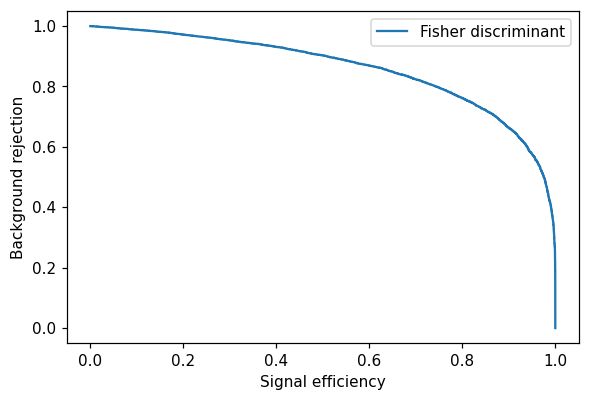

In [ ]:
from sklearn.metrics import roc_curve
bkgRej, sigRej, _ = roc_curve (isSignal, fisher[:,0])
plt.plot ( 1.-sigRej, bkgRej, label = 'Fisher discriminant' )
plt.xlabel ("Signal efficiency")
plt.ylabel ("Background rejection")
plt.legend()
plt.show ()

It is now immediate to compare the ROC curve obtained with Fisher discriminant with the one obtained with a Logistic regression.

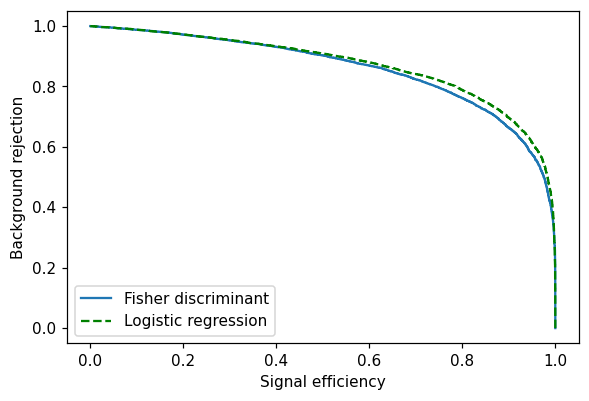

In [ ]:
## We obtain the dataset
xy = dataset[['drll', 'mTi']].values
isSignal = (dataset['label'] == 1)

## Import, instanciate and fit the logistic regression algorith, 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit (xy, isSignal)

## Compute the test-statistic from the logistic regression
logistic_regression = lr.predict_proba(xy)

## Compute the two ROC curves
f_bkgRej, f_sigRej, _ = roc_curve (isSignal, fisher[:,0])
l_bkgRej, l_sigRej, _ = roc_curve (isSignal, logistic_regression[:,0])

## And plot them 
plt.plot ( 1.-f_sigRej, f_bkgRej, '-', label = 'Fisher discriminant' )
plt.plot ( 1.-l_sigRej, l_bkgRej, '--', label = 'Logistic regression', color='green' )
plt.xlabel ("Signal efficiency")
plt.ylabel ("Background rejection")
plt.legend()
plt.show ()

Finally, as we did before, we superpose to the scatter plot the boundaries obtained from the logistic regression. 

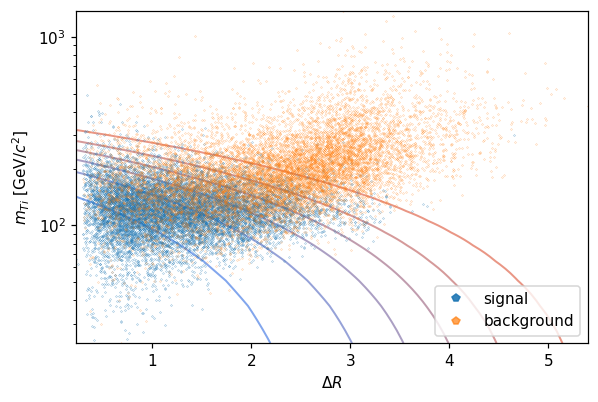

In [ ]:
## Get the dataset
xy = dataset[['drll', 'mTi']].values

## Create a grid xy of 100 x 100 
x_ = np.linspace ( xy[:,0].min(), xy[:,0].max(), 100 )
y_ = np.linspace ( xy[:,1].min(), xy[:,1].max(), 100 )
xy = np.dstack(np.meshgrid(x_, y_)).reshape((-1, 2))

## For each point of the grid, we evaluate the test-statistic
logistic_regression = lr.predict_proba(xy)

## Then we plot the scatter plot
make_2d_plot('drll', 'mTi', "$\Delta R$", "$m_{Ti}\  [\mathrm{GeV}/c^2]$")

## and superpose the contour plot of the test-statistic
plt.contour (x_, y_, logistic_regression[:,1].reshape((100,100)), 
             colors=colors, linewidths=1.3, alpha = 0.7)

plt.yscale ('log')
plt.show()

The great advance of the Fisher discriminant is that it can be trained using an analytically-derived set of operations, without relying on numerical minimization. This allows to obtain an effective and fast training procedure, even if it results in a slightly less performant tool.

Can we improve the performance of the Fisher discriminant? 

A common technique to improve the performance of linear algorithms is to expand the set of variables by including higher powers of the variables used for the training. 
The analytical algorithms can often deal with a large number of input variables, so that it may be better to apply an algorithm with analytical solution on a large number of variables than an algorithm requiring a numerical minimization on a small number of variables. 

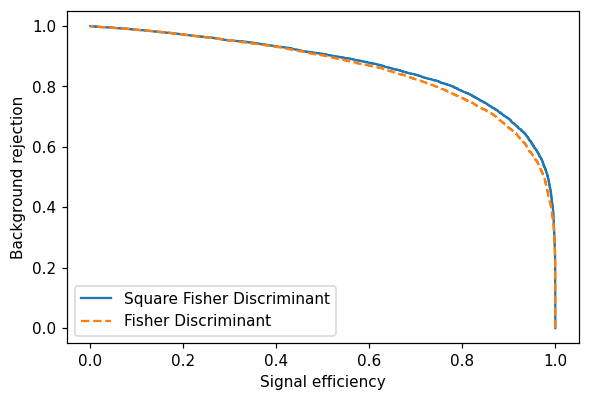

In [ ]:
## Load the dataset
xy = dataset[['drll', 'mTi']].values
isSignal = (dataset['label'] == 1)

## Train a Fisher discriminant on two variables  
lr = LinearDiscriminantAnalysis()
lr.fit (xy, isSignal)
logistic_regression = lr.predict_proba(xy)

## Expand the set of variables to a new dataset multiplying x*x, y*y and x*y 
X = np.c_[xy,xy**2, xy[:,0]*xy[:,1]]

## Train the Fisher discriminant on the new set of variables
lr2 = LinearDiscriminantAnalysis()
lr2.fit (X, isSignal)
logistic_regression2 = lr2.predict_proba(X)

## Compute the ROC curves 
l_bkgRej, l_sigRej, _   = roc_curve (isSignal, logistic_regression [:,0])
l_bkgRej2, l_sigRej2, _ = roc_curve (isSignal, logistic_regression2[:,0])

## Plot the ROC curves 
plt.plot ( 1.-l_sigRej2, l_bkgRej2, '-',  label = 'Square Fisher Discriminant' )
plt.plot ( 1.-l_sigRej,  l_bkgRej,  '--', label = 'Fisher Discriminant' )
plt.xlabel ("Signal efficiency")
plt.ylabel ("Background rejection")
plt.legend()
plt.show ()

Indeed, we observe a slight improvement in performance, despite the information available to the algorithm is exactly the same, thanks to the expansion into a multilinear problem.
This technique is useful also with more advanced algorithms and should also be considered when there is something special in the method used for training an algorithm (such as the possibility of performing an analytical training).

## More than two variables

Before exploring more complex algorithms, let's try to explore what happens trying to use more than two variables to perform the classification. 

Let's list all the variables that we can used for classification. Basically, all of them with the exception of the `label` (with which we would achieve perfect classification) and the number of jets `njet` which is a discrete variable.

In [ ]:
all_variables = [v for v in dataset.columns if v not in ['label', 'njet']]

isSignal = (dataset['label'] == 1)
nSig = np.count_nonzero ( isSignal)
nBkg = np.count_nonzero (~isSignal)  

Then we loop over all the possible combination of variables and we train and evaluate the performance of a Fisher discriminant. 

We will use the Kolmogorov Distance as metric.

In [ ]:
## Define the axis for the compuation of the Kolmogorv Distance
axis = np.linspace(0,1,100)

## Import the combinations tool to run over the possible combinations 
from itertools import combinations

## tqdm is a powerful tool to keep track of the progress of some process 
from tqdm import trange

## Initialize a list of results. 
results = list()

## For each number of variables nVariables in the range (1, all_variables)
for nVariables in trange(1, len(all_variables)):
  ## and for each combination of nVariables variables
  for variables in combinations (all_variables, nVariables):
    ## Load the dataset for the chosen set of variables 
    X = dataset[list(variables)].values

    ## Instanciate and fit the Fisher discriminant  
    lr = LinearDiscriminantAnalysis()
    lr.fit (X, dataset['label'].values)

    ## Compute the probability 
    p = lr.predict_proba(X)

    ## Compute the Kolmogorov Distance 
    s_c = np.cumsum ( np.histogram (p[isSignal,1],  bins = axis)[0] ) / nSig
    b_c = np.cumsum ( np.histogram (p[~isSignal,1], bins = axis)[0] ) / nBkg

    kdist = np.max ( np.abs ( s_c - b_c ) )

    ## Register in the list of the results the set of variables and the 
    ## corresponding metric. 
    results.append ((variables, kdist))

100%|██████████| 9/9 [01:01<00:00,  6.87s/it]


Intuitively, adding more variables enhance the information available to the algorthm to draw conclusion on the category to which each entries belongs to, and therefore we expect the performance to increase while when the number of variables increase.

Let's check by plotting the highest obtained Kolmogorov Distance per number of variables used for training. 

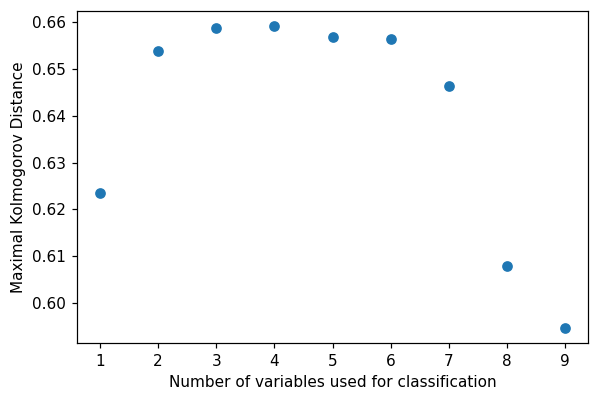

In [ ]:
## Organize the results per number of variables used for training 
per_varlen = [[] for _ in range(30)]
for vars, kd in results:
  per_varlen [len(vars)].append ( kd )

## For each set of variables takes the highest Kolmogorv Distance 
best = [np.max(kds) if len(kds) else 0 for kds in per_varlen]

## Plot the result as a function of the number of variables 
plt.plot (range(1,10), best[1:10] , 'o')
plt.xlabel ( "Number of variables used for classification")
plt.ylabel ( "Maximal Kolmogorov Distance")
plt.show()

**Surprise!**

Up to three-four variables adding variables allows to increase the performance of the classifier.

**BUT**

Adding variables beyond those three or four variables worsen the performance of the classifier. This happens because adding more variables makes it harder for the classifier to distinguish random fluctuations from real, statistically relevant differences between the two distributions. 

This effect is known as **the curse of dimensionality**. 

Different algorithms behave differently in presence of many variables, but in general it is not true that adding more variables enhance the performance of the algorithm.
In the specific case of the Fisher Discriminant, adding more variables makes the description of the probabiliity density function as a Gaussian less effective. 

### Exercise 2.2
Compare logistic regression and the Fisher discriminant for the best set of TWO input variables.

('mll', 'mth') 0.6537581250572186


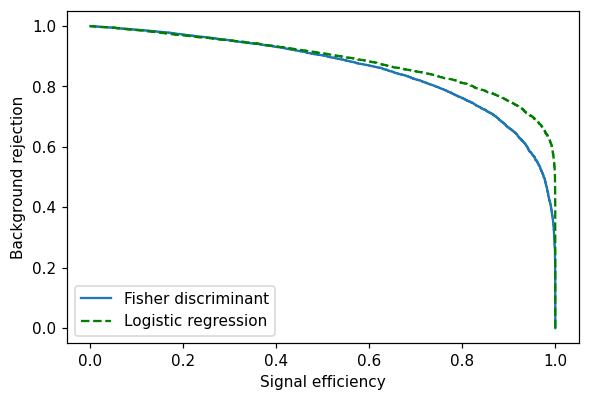

In [ ]:
## Find the best set of variables
filtered_results = [(k,v) for k,v in results if len(k) == 2]
best_varset, best_kd = sorted(filtered_results, key=lambda kv:-kv[1])[0]
print (best_varset, best_kd)

xy = dataset[list(best_varset)].values
isSignal = (dataset['label'] == 1)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit (xy, isSignal)

logistic_regression = lr.predict_proba(xy)

f_bkgRej, f_sigRej, _ = roc_curve (isSignal, fisher[:,0])
l_bkgRej, l_sigRej, _ = roc_curve (isSignal, logistic_regression[:,0])
plt.plot ( 1.-f_sigRej, f_bkgRej, '-', label = 'Fisher discriminant' )
plt.plot ( 1.-l_sigRej, l_bkgRej, '--', label = 'Logistic regression', color='green' )
plt.xlabel ("Signal efficiency")
plt.ylabel ("Background rejection")
plt.legend()
plt.show ()

### Exercise 2.3
Compare the scatter plots of the combination of the two variables that are the most discriminant taken singularly with the scatter plot of the most discriminant pair of variables (as identified in Ex. 2.2).

Why they are not the same pair of variables?


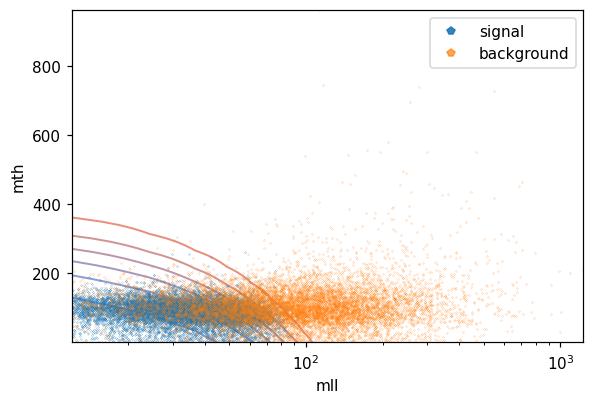

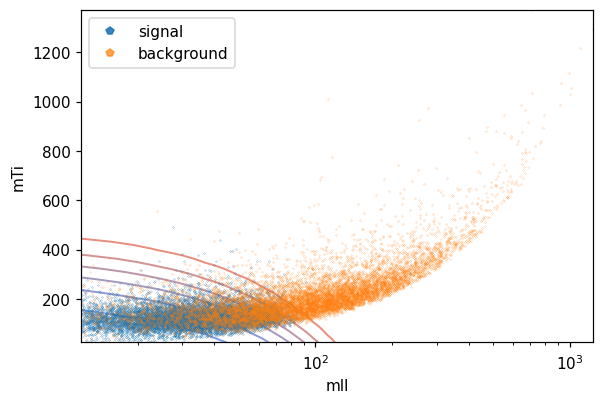

In [ ]:
for varset in [best_varset, ('mll', 'mTi')]:
  xy = dataset[list(varset)].values
  lr = LogisticRegression()
  lr.fit(xy, dataset['label'].values)

  x_ = np.linspace ( xy[:,0].min(), xy[:,0].max(), 100 )
  y_ = np.linspace ( xy[:,1].min(), xy[:,1].max(), 100 )

  xy = np.dstack(np.meshgrid(x_, y_)).reshape((-1, 2))
  logistic_regression = lr.predict_proba(xy)

  make_2d_plot(*varset)
  plt.contour (x_, y_, logistic_regression[:,1].reshape((100,100)), 
               colors=colors, linewidths=1.3, alpha = 0.75)
  plt.xscale ('log')
  plt.yscale ('linear')
  plt.show()